# Chinese and Western Instrument Timbre Dataset Explorations

In [1]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import re
from msclap import CLAP
from datasets import load_dataset
import json
import os

In [1]:



CACHE_DIR = "/nfs/guille/eecs_research/soundbendor/mccabepe/timbre_tags/.cache"

os.environ['HF_HOME'] = CACHE_DIR

chit = load_dataset("ccmusic-database/instrument_timbre")

chit_df = pd.concat([pd.DataFrame(chit["Chinese"]),pd.DataFrame(chit["Western"])],ignore_index=True)
START_NUMERIC_COL_ID = 3

SCALE_CENTER = 4.5 # center of 9-point scale used in dataset creation



label distributions. Notice two peaks around 4 and 6.

<Axes: ylabel='Density'>

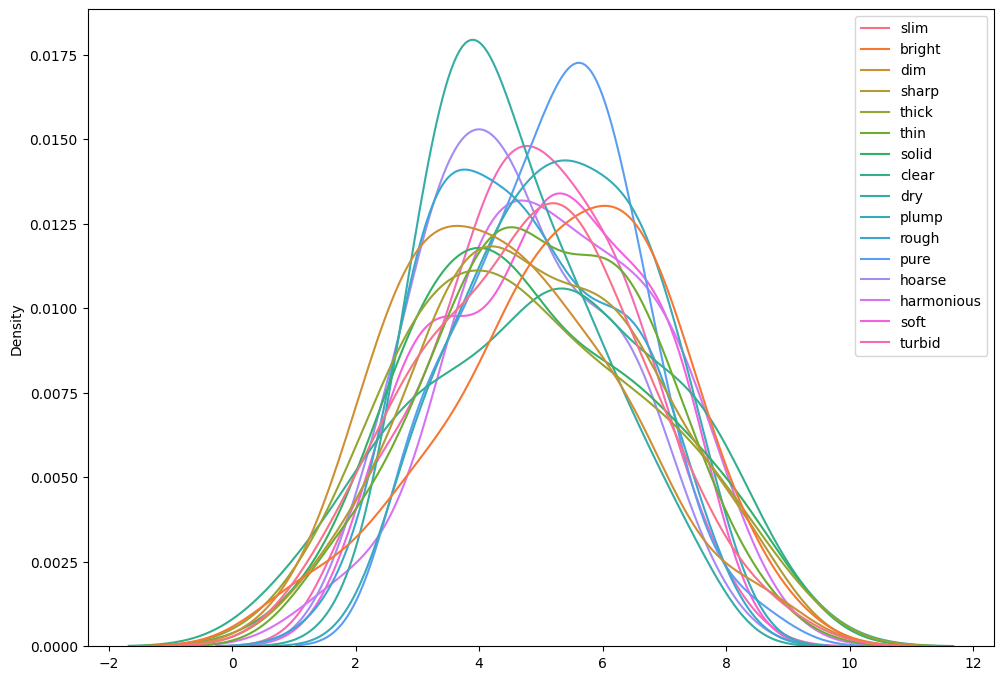

In [11]:
A4_DIMS = (11.7, 8.27)
fig,ax = plt.subplots(figsize=A4_DIMS)
sns.kdeplot(chit_df.iloc[:,START_NUMERIC_COL_ID:])

<Axes: ylabel='Count'>

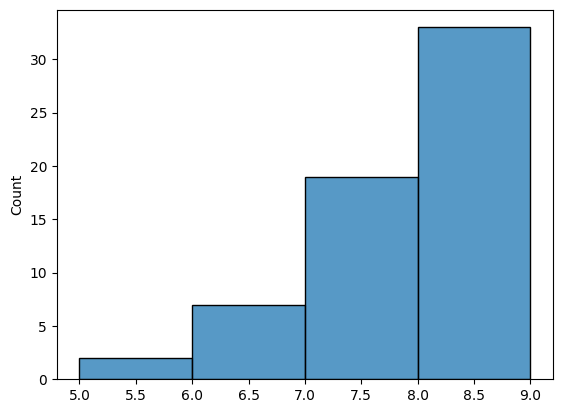

In [12]:
for name,col in list(chit_df.items())[START_NUMERIC_COL_ID:]:
  chit_df[f"{name}_bool"] = col > SCALE_CENTER # substitute mean or median etc

START_BOOL_COL_ID = 19
chit_label_data = chit_df.iloc[:,START_BOOL_COL_ID:].to_numpy()

counts = np.sum(chit_label_data,axis=1)

sns.histplot(counts,binwidth=1)

The vast majority of instruments have 8/16 labels present, another sizeable chunk have 7/16, and the rest have only 5 or 6. That means that no instrument has more than half of the labels, nor less than 5. Let's see how the mean or median affect this distribution

Text(0.5, 0, 'Labels Greater Than Median')

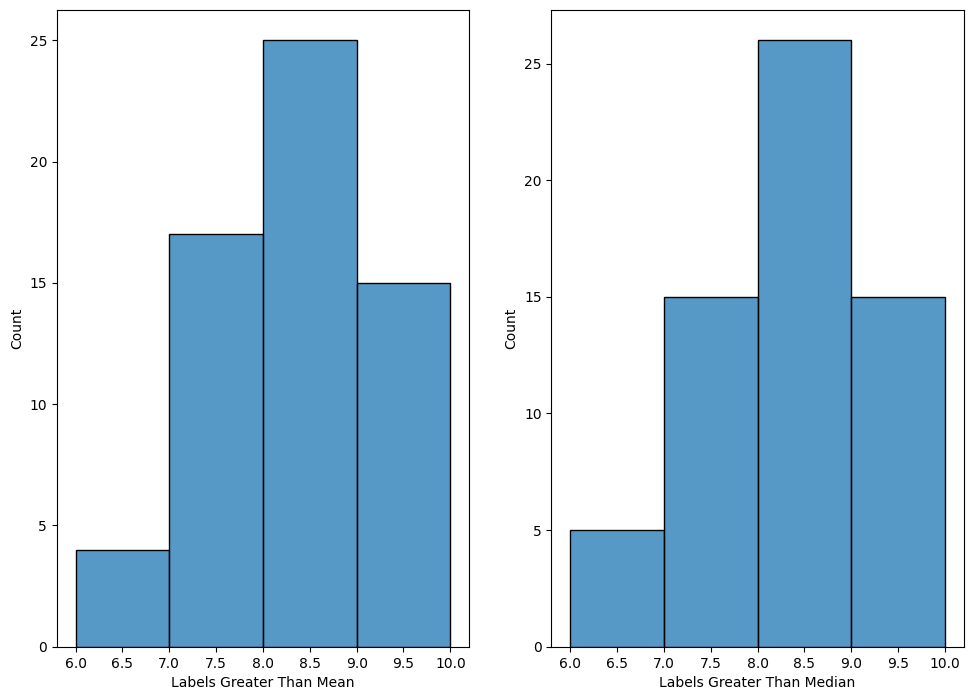

In [13]:
means = chit_df.iloc[:,START_NUMERIC_COL_ID:START_BOOL_COL_ID].mean(axis=0)
medians = chit_df.iloc[:,START_NUMERIC_COL_ID:START_BOOL_COL_ID].median(axis=0)
mean_bools = chit_df.iloc[:,START_NUMERIC_COL_ID:START_BOOL_COL_ID].gt(means,axis=1)
median_bools = chit_df.iloc[:,START_NUMERIC_COL_ID:START_BOOL_COL_ID].gt(medians,axis=1)

mean_counts = np.sum(mean_bools,axis=1)
median_counts = np.sum(median_bools,axis=1)

fig,ax = plt.subplots(1,2,figsize=A4_DIMS)
sns.histplot(mean_counts,binwidth=1,ax=ax[0])
ax[0].set_xlabel("Labels Greater Than Mean")
sns.histplot(median_counts,binwidth=1,ax=ax[1])
ax[1].set_xlabel("Labels Greater Than Median")

Clearly, the median and mean create very similar results, but they 

In [14]:

audio_paths = chit_df['audio'].str['path']

chit_tags = list(chit_df.columns[START_NUMERIC_COL_ID:START_BOOL_COL_ID])

chit_tags_list = []
for row in chit_label_data:
    sublist = [chit_tags[i] for i in range(len(row)) if row[i]]
    chit_tags_list.append(sublist)

chit_tag_prompts = [f"An instrument with a {''.join(f'{t}, ' for t in tag_list)}timbre." for tag_list in chit_tags_list]

In [15]:

clap = CLAP(version='2023',use_cuda=False)

chit_audio_embeddings = clap.get_audio_embeddings(audio_paths,resample=True)
chit_text_embeddings = clap.get_text_embeddings(chit_tag_prompts)


In [ ]:
audio_norm = np.linalg.norm(chit_audio_embeddings.cpu(),ord=np.inf,axis=1)
text_norm = np.linalg.norm(chit_text_embeddings.cpu(),ord=np.inf,axis=1)
np.var(np.abs(audio_norm-text_norm))

In [ ]:
alt_prompts = [f"{''.join(f'{t}, ' for t in tag_list)}" for tag_list in chit_tags]
print(alt_prompts[0])
alternate_text_embeddings = clap.get_text_embeddings(alt_prompts)
alt_t_norm = np.linalg.norm(alternate_text_embeddings.cpu(),ord=np.inf,axis=1)
np.var(np.abs(audio_norm-alt_t_norm))

The more specific prompt led to smaller variance in the Chebyschev distance, so I think I will use that value. Theoretically, the most precise description would be as close as possible to the audio embedding, so using a more precise prompt should get us a better approximation of the distance between the audio and text modalities in the space.

## AudioCommons timbre dataset

In [ ]:
boom_df = pd.read_pickle("../data/ACTD_Boominess.pickle")
bright_df = pd.read_pickle("../data/ACTD_Brightness.pickle")
depth_df = pd.read_pickle("../data/ACTD_Depth.pickle")
hard_df = pd.read_pickle("../data/ACTD_Hardness.pickle")
rough_df = pd.read_pickle("../data/ACTD_Roughness.pickle")
sharp_df = pd.read_pickle("../data/ACTD_Sharpness.pickle")
warmth_df = pd.read_pickle("../data/ACTD_Warmth.pickle")

dfs = [boom_df,bright_df,depth_df,hard_df,rough_df,sharp_df,warmth_df]

In [ ]:
print([df.shape for df in dfs])

[(102, 7), (211, 14), (218, 16), (206, 18), (212, 16), (165, 7), (184, 14)]


In [ ]:
boom_df.head()

,sound_file,rating_3,rating_2,rating_4,rating_5,rating_6,rating_1
0,bass-booming-2-157245.wav,73.0,33.0,84.0,31.0,89.0,62.0
1,bass-booming-5-276738.wav,57.0,63.0,84.0,36.0,62.0,78.0
2,bass-boomy-1-185819.wav,29.0,6.0,71.0,19.0,50.0,39.0
3,bass-default-1-61820.wav,29.0,5.0,80.0,0.0,33.0,8.0
4,bass-default-11-306796.wav,0.0,3.0,10.0,0.0,28.0,17.0


Not every timbral characteristic has the same number of samples nor the same number of columns

In [ ]:
import pingouin as pg
pg_boom = pd.melt(boom_df, id_vars=['sound_file'], var_name='rater', value_name='rating')

icc = pg.intraclass_corr(pg_boom,targets="sound_file",raters="rater",ratings="rating")
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.438608,5.687719,101,510,2.320699e-40,"[0.35, 0.53]"
1,ICC2,Single random raters,0.463958,11.500359,101,505,4.471390e-82,"[0.27, 0.62]"
2,ICC3,Single fixed raters,0.636372,11.500359,101,505,4.471390e-82,"[0.56, 0.71]"
3,ICC1k,Average raters absolute,0.824183,5.687719,101,510,2.320699e-40,"[0.77, 0.87]"
4,ICC2k,Average random raters,0.838531,11.500359,101,505,4.471390e-82,"[0.69, 0.91]"
5,ICC3k,Average fixed raters,0.913046,11.500359,101,505,4.471390e-82,"[0.88, 0.94]"


Checking the intra-class correlation, we see that for all dataframes, the average raters ICC is quite high. Since I will be using this in the context of averaging score to determine class identity, I care anout the averaging scores.  The lowest value is the ICC1k boominess value, at ~0.82 which shows that the raters are on average agreeing. 

In [ ]:
def booleanize_ac(df,name):
    new_df = {"sound_file":df.sound_file,
              name: (df.iloc[:,1:].mean(axis=1) >= 50).astype(np.int8)}
    return pd.DataFrame(new_df)

col_names = ["Boominess","Brightness","Depth","Hardness","Roughness","Sharpness","Warmth"]
bool_dfs = [booleanize_ac(df,name) for df,name in zip(dfs,col_names)]

In [ ]:
combined_df = None
for df in bool_dfs:
    if combined_df is None:
            combined_df = df
    else:
        combined_df = pd.merge(combined_df, df, on='sound_file', how='outer')
        print(f"Shape of df after merge: {combined_df.shape}")


Shape of df after merge: (313, 3)
Shape of df after merge: (531, 4)
Shape of df after merge: (737, 5)
Shape of df after merge: (949, 6)
Shape of df after merge: (1114, 7)
Shape of df after merge: (1298, 8)


In [ ]:
combined_df.head()

,sound_file,Boominess,Brightness,Depth,Hardness,Roughness,Sharpness,Warmth
0,alarm-default-31-336890.wav,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,alarm-default-34-52053.wav,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,alarm-default-49-268823.wav,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,ambience-000-default-3-33185.wav,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,ambience-028-soft-7-190835.wav,NaN,NaN,NaN,0.0,NaN,NaN,NaN


Use their model

In [4]:
import timbral_models
audio_path = "/nfs/guille/eecs_research/soundbendor/datasets/sounds_and_noise/AudioCommonsTimbre/TimbralModels_v0.2_Development/Boominess/Boominess ratings/Listening tests/Stimuli/waves-default-49-368476.wav"
example_result = timbral_models.timbral_extractor(audio_path)
example_result

Calculating hardness...
Calculating depth...
Calculating brightness...
Calculating roughness...
Calculating warmth...
Calculating sharpness...
Calculating boominess...
Calculating reverb...


{'hardness': 60.14916396936971,
 'depth': 58.04110011832127,
 'brightness': 64.75086530489558,
 'roughness': 57.72650310010699,
 'warmth': 47.90348642378783,
 'sharpness': 54.13101134232997,
 'boominess': 26.546667706823044,
 'reverb': 1}

In [31]:
import os
from tqdm import tqdm
def consilidate_wavs(directory):

    results = []
    file_set = set()
    for root, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith(".wav"):
                if file not in file_set:
                    filepath = os.path.join(root, file)
                    try:
                        result = timbral_models.timbral_extractor(filepath,verbose=False)
                        result["sound_file"] = file
                        results.append(result)
                    except Exception as e:
                        print(f"File {file} caused error {e}")
                    
                    file_set.add(file)

    # Convert the results list into a DataFrame
    df = pd.DataFrame(results)
    df = df.set_index("sound_file")
    df["reverb"] = df.reverb.astype("bool")

    return df

In [32]:
test_small_set = "../data/test_sounds"
tm_approx_df = consilidate_wavs(test_small_set)

1it [00:06,  6.16s/it]


,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb
sound_file,,,,,,,,
bright_cheerful_clip.wav,False,False,False,False,False,False,False,False
scales_c_fast_piano_a.wav,False,False,True,False,False,False,False,True


In [3]:
import pandas as pd
paths = pd.read_pickle("/nfs/guille/eecs_research/soundbendor/mccabepe/timbre_tags/data/ac_paths.pickle")


In [4]:
paths.nunique()

path    5574
dtype: int64

In [6]:
ACTD = pd.read_pickle("/nfs/guille/eecs_research/soundbendor/mccabepe/timbre_tags/data/audiocommons/AC_dataset.pickle")
ACTD.head()

,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb
sound_file,,,,,,,,
Alignment Noise -14dBFS.wav,True,True,True,True,False,True,False,True
synth-default-2-9776.wav,True,False,True,True,False,True,False,True
hit-default-8-234607.wav,True,False,True,True,False,True,False,False
strings-default-33-373825.wav,True,False,True,False,False,False,False,False
guitar-default-16-97774.wav,False,True,True,False,False,False,False,True


In [9]:

import os
paths['extracted_filename'] = paths["path"].apply(lambda x: os.path.basename(x))


matched_df = pd.merge(paths, ACTD, left_on='extracted_filename', right_on="sound_file", how='inner')


matched_df = matched_df.drop(columns=['extracted_filename'])

matched_df.head()

,path,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb
0,/nfs/guille/eecs_research/soundbendor/datasets...,True,True,True,True,False,True,False,True
1,/nfs/guille/eecs_research/soundbendor/datasets...,True,False,True,True,False,True,False,True
2,/nfs/guille/eecs_research/soundbendor/datasets...,True,False,True,True,False,True,False,False
3,/nfs/guille/eecs_research/soundbendor/datasets...,True,False,True,False,False,False,False,False
4,/nfs/guille/eecs_research/soundbendor/datasets...,False,True,True,False,False,False,False,True


In [11]:
pd.to_pickle(matched_df,"/nfs/guille/eecs_research/soundbendor/mccabepe/timbre_tags/data/audiocommons/AC_dataset.pickle")